# Spooky Author Identification

![cthulhu](https://i.pinimg.com/originals/2a/9f/54/2a9f54dee6d1368c7e8bacf686c6ea2b.jpg)


Целта тук е да се опитаме да предскажем кой от тримата автори (Лъвркафт, Едгар Алан По и Мери Шели) е написал даден текст.

Ще се опитам да подобря резултата, представен на [лекцията](http://fmi.machine-learning.bg/lectures/08-spooky-author-identification), използвайки nltk и model stacking.


In [43]:
import sys

import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB

import string
import nltk
from nltk import word_tokenize

%matplotlib inline

За да използваме nltk, трябва предварително да изтеглим следните неща:

In [44]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('tagsets')

In [45]:
train = pd.read_csv("data/spooky-author/train.zip", index_col=['id'])
test = pd.read_csv("data/spooky-author/test.zip", index_col=['id'])
sample_submission = pd.read_csv("data/spooky-author/sample_submission.zip", index_col=['id'])

In [46]:
train.head()

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


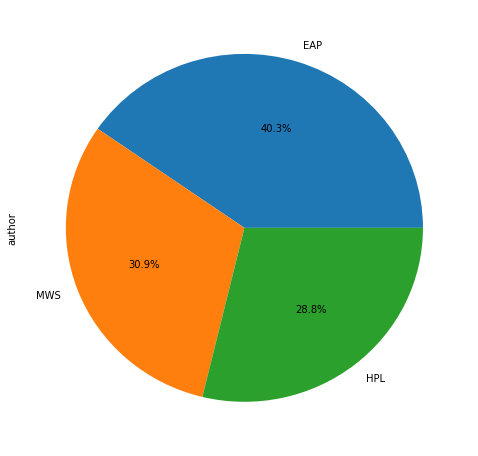

In [47]:
train.author.value_counts().plot.pie(figsize=(8, 8), autopct='%1.1f%%');

Първото нещо, което ще пробваме, е да извлечем информация за това колко често авторите използват частите на речта. Тоест ще броим колко пъти се срещат прилагателни, съществителни, глаголи и тн. в текстовете.

За целта ще използваме библиотеката nltk. Първо ще сплитнем изреченията по думи, като използваме word_tokenize:

In [48]:
first_sentence = train.iloc[0][0]
first_stence_tokenized = word_tokenize(first_sentence)
first_stence_tokenized

['This',
 'process',
 ',',
 'however',
 ',',
 'afforded',
 'me',
 'no',
 'means',
 'of',
 'ascertaining',
 'the',
 'dimensions',
 'of',
 'my',
 'dungeon',
 ';',
 'as',
 'I',
 'might',
 'make',
 'its',
 'circuit',
 ',',
 'and',
 'return',
 'to',
 'the',
 'point',
 'whence',
 'I',
 'set',
 'out',
 ',',
 'without',
 'being',
 'aware',
 'of',
 'the',
 'fact',
 ';',
 'so',
 'perfectly',
 'uniform',
 'seemed',
 'the',
 'wall',
 '.']

Виждаме, че е включило и препинателните знаци, но това не е проблем за pos tagger-a.

След като имаме токените, може да го прекараме през pos_tag. Това ще направи part-of-speech tagging, като за всеки токен (дума), ще предположи каква част на речта е.

In [49]:
nltk.pos_tag(first_stence_tokenized)

[('This', 'DT'),
 ('process', 'NN'),
 (',', ','),
 ('however', 'RB'),
 (',', ','),
 ('afforded', 'VBD'),
 ('me', 'PRP'),
 ('no', 'DT'),
 ('means', 'NNS'),
 ('of', 'IN'),
 ('ascertaining', 'VBG'),
 ('the', 'DT'),
 ('dimensions', 'NNS'),
 ('of', 'IN'),
 ('my', 'PRP$'),
 ('dungeon', 'NN'),
 (';', ':'),
 ('as', 'IN'),
 ('I', 'PRP'),
 ('might', 'MD'),
 ('make', 'VB'),
 ('its', 'PRP$'),
 ('circuit', 'NN'),
 (',', ','),
 ('and', 'CC'),
 ('return', 'NN'),
 ('to', 'TO'),
 ('the', 'DT'),
 ('point', 'NN'),
 ('whence', 'NN'),
 ('I', 'PRP'),
 ('set', 'VBP'),
 ('out', 'RP'),
 (',', ','),
 ('without', 'IN'),
 ('being', 'VBG'),
 ('aware', 'JJ'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('fact', 'NN'),
 (';', ':'),
 ('so', 'RB'),
 ('perfectly', 'RB'),
 ('uniform', 'JJ'),
 ('seemed', 'VBD'),
 ('the', 'DT'),
 ('wall', 'NN'),
 ('.', '.')]

За повече информация кой таг какво значи:

In [50]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

Ще извлечем броя на:
* съществителните
* прилагателните
* глаголите
* наречията
* съюзите
* чужди думи.

За целта, ще си дефинираме списъци от таговете, които отговарят за всеки от тях.

In [51]:
NOUN_TAGS = ['NN','NNP','NNPS','NNS']
ADJECTIVE_TAGS = ['JJ','JJR','JJS']
VERB_TAGS = ['VB','VBD','VBG', 'VBN', 'VBP', 'VBZ']
ADVERB_TAGS = ['RB','RBR','RBS']
CONJUNCTION_TAGS = ['CC']
FOREIGN_WORD_TAGS = ['FW']

И функции, които ги използват:

In [52]:
def count_pos(text, tags):
    tokenized = word_tokenize(text)
    pos_tagged = nltk.pos_tag(tokenized)
    return sum([tag in tags for word, tag in pos_tagged])

def count_nouns(text):
    return count_pos(text, NOUN_TAGS)

def count_adjectives(text):
    return count_pos(text, ADJECTIVE_TAGS)

def count_verbs(text):
    return count_pos(text, VERB_TAGS)

def count_adverbs(text):
    return count_pos(text, ADVERB_TAGS)

def count_conjunctions(text):
    return count_pos(text, CONJUNCTION_TAGS)

def count_foreign_words(text):
    return count_pos(text, FOREIGN_WORD_TAGS)

**NB:** Тази част отнема известно време.

In [53]:
explore_pos = train.copy()

explore_pos['nouns_count'] = train.text.apply(count_nouns)
explore_pos['adjectives_count'] = train.text.apply(count_adjectives)
explore_pos['verbs_count'] = train.text.apply(count_verbs)
explore_pos['adverbs_count'] = train.text.apply(count_adverbs)
explore_pos['conjuncions_count'] = train.text.apply(count_conjunctions)
explore_pos['foreign_words_count'] = train.text.apply(count_foreign_words)

In [54]:
features_names = list(set(explore_pos.columns) - {'text', 'author'})
features_names

['verbs_count',
 'foreign_words_count',
 'adjectives_count',
 'conjuncions_count',
 'adverbs_count',
 'nouns_count']

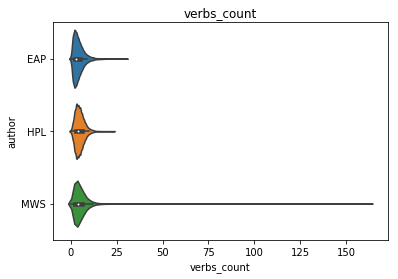

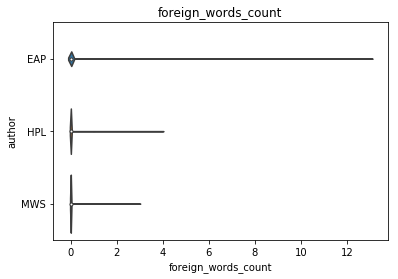

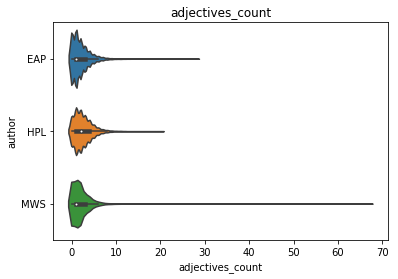

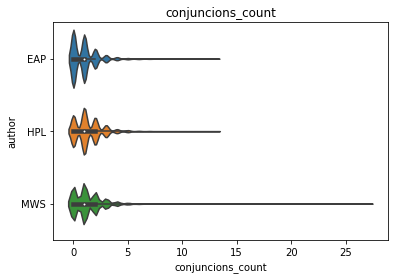

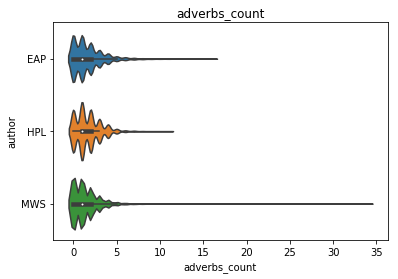

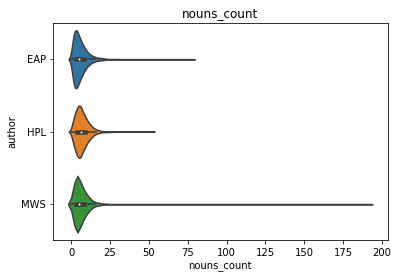

In [55]:
for feature in features_names:
    plt.figure()
    sns.violinplot(x=feature, y="author", data=explore_pos)
    plt.title(feature);

In [56]:
explore_pos.loc[explore_pos['foreign_words_count'] > 0, 'author'].value_counts()

EAP    99
HPL    22
MWS    12
Name: author, dtype: int64

Виждат се леки разлики при различните автори, особено при използването на чуждите думи. Все пак оставим и останалите, може да ни помогнат при класификацията.

Ще добавим и още малко данни за текстовете, като брой на уникални думи, пунктуация, stop words и тн.

За броене на stop words и отделяне на изреченията отново използвам nltk.

In [57]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
stopwords = nltk.corpus.stopwords.words('english')

def get_text_metadata(df):
    explore = df.copy()
    
    explore['average_word_length'] = explore.text.apply(lambda s: pd.np.mean([len(w) for w in str(s).split()]))
    explore['unique_words'] = explore.text.apply(lambda s: len(set(str(s).split())))
    explore['words_occuring_twice'] = explore.text.apply(lambda s: sum([s.count(w) == 2 for w in str(s).split()]))
    explore["punctuation"] = explore.text.apply(lambda s: sum([c in string.punctuation for c in str(s)]) )
    explore["words_starting_with_capital"] = explore.text.apply(lambda s: sum([w[0].isupper() for w in str(s).split()]))
    explore["quotes"] = explore.text.apply(lambda s: s.count('"'))

    explore['words_per_sentence'] = explore.text.apply(lambda text: pd.np.mean([len(str(sentence).split()) for sentence in tokenizer.tokenize(text)]))
    explore['stop_words'] = explore.text.apply(lambda s: sum(w in stopwords for w in str(s).split()))
    
    return explore

In [58]:
get_text_metadata(train).head(10)

,text,author,average_word_length,unique_words,words_occuring_twice,punctuation,words_starting_with_capital,quotes,words_per_sentence,stop_words
id,,,,,,,,,,
id26305,"This process, however, afforded me no means of...",EAP,4.658537,35,3,7,3,0,41.0,16
id17569,It never once occurred to me that the fumbling...,HPL,4.142857,14,1,1,1,0,14.0,7
id11008,"In his left hand was a gold snuff box, from wh...",EAP,4.583333,32,6,5,1,0,36.0,15
id27763,How lovely is spring As we looked from Windsor...,MWS,5.088235,32,5,4,4,0,34.0,11
id12958,"Finding nothing else, not even gold, the Super...",HPL,5.481481,25,4,4,2,0,27.0,11
id22965,"A youth passed in solitude, my best years spen...",MWS,4.650602,66,2,6,5,0,83.0,38
id09674,"The astronomer, perhaps, at this point, took r...",EAP,5.142857,21,0,5,1,0,21.0,8
id13515,The surcingle hung in ribands from my body.,EAP,4.500000,8,1,1,1,0,8.0,3
id19322,I knew that you could not say to yourself 'ste...,EAP,4.556818,62,6,11,7,0,88.0,41


Да направим функция, която обединява всички трансформации.

In [59]:
def transform_data(df):
    explore = df.copy()

    explore['nouns_count'] = explore.text.apply(count_nouns)
    explore['adjectives_count'] = explore.text.apply(count_adjectives)
    explore['verbs_count'] = explore.text.apply(count_verbs)
    explore['adverbs_count'] = explore.text.apply(count_adverbs)
    explore['conjuncions_count'] = explore.text.apply(count_conjunctions)
    explore['foreign_words_count'] = explore.text.apply(count_foreign_words)

    explore = get_text_metadata(explore)
    
    return explore

In [60]:
train_transformed = transform_data(train)
test_transformed = transform_data(test)

In [61]:
train_transformed.head()

,text,author,nouns_count,adjectives_count,verbs_count,adverbs_count,conjuncions_count,foreign_words_count,average_word_length,unique_words,words_occuring_twice,punctuation,words_starting_with_capital,quotes,words_per_sentence,stop_words
id,,,,,,,,,,,,,,,,
id26305,"This process, however, afforded me no means of...",EAP,10,2,6,3,1,0,4.658537,35,3,7,3,0,41.0,16
id17569,It never once occurred to me that the fumbling...,HPL,2,1,2,2,0,0,4.142857,14,1,1,1,0,14.0,7
id11008,"In his left hand was a gold snuff box, from wh...",EAP,10,5,4,1,0,0,4.583333,32,6,5,1,0,36.0,15
id27763,How lovely is spring As we looked from Windsor...,MWS,10,6,5,1,2,0,5.088235,32,5,4,4,0,34.0,11
id12958,"Finding nothing else, not even gold, the Super...",HPL,7,1,5,4,1,0,5.481481,25,4,4,2,0,27.0,11


б

In [62]:
features_names = list(set(train_transformed.columns) - {'text', 'author'})
features_names

['quotes',
 'words_per_sentence',
 'verbs_count',
 'words_starting_with_capital',
 'conjuncions_count',
 'punctuation',
 'adverbs_count',
 'nouns_count',
 'words_occuring_twice',
 'foreign_words_count',
 'unique_words',
 'stop_words',
 'adjectives_count',
 'average_word_length']

Да видим какъв резултат ще постигнем само с тези фийчъри.

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier()
cross_val_score(rfc, train_transformed[features_names], train_transformed.author, cv=10, n_jobs=3)

array([ 0.48749362,  0.48289944,  0.48443083,  0.44716692,  0.46833504,
        0.48032703,  0.49105774,  0.48543689,  0.48288196,  0.46244251])

Доста слабо, но това е очаквано. Видяхме, че няма кой знае какви различия между авторите при тези фийчъри.


На лекциите разгледахме основно Bag-Of-Words под формата на CountVectorizer и TfidfVectorizer, които дадоха доста по-добри резултати. Затова ще пробваме да обединим фийчърите, намерени от тях, с нашите.

С това има един проблем - CountVectorizer и TfidfVectorizer връщат sparse матрици. Тъй като лаптопа ми не може да го понесе, не е вариант да ги преобразуваме до dense матрици и да работим с тях. 

Тогава ще използваме друго - model stacking. За целта ще предиктнем вероятностите с един модел, използващ само Bag-Of-Words фийчърите и ще ги запишем като колони в дейтафрейма с нашите фийчъри.

In [64]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

TEXT_COLUMN = 'text'

PREDICT_PROBA_TRAIN_ROWS = train.shape[0]
PREDICT_PROBA_TRAIN_COLUMNS = 3

PREDICT_PROBA_TEST_ROWS = test.shape[0]
PREDICT_PROBA_TEST_COLUMNS = 3

y = train.author


def run_stratifiedkfold(train, global_test, cv=5):
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    cv_scores = []
    predict_proba_train = pd.np.zeros([PREDICT_PROBA_TRAIN_ROWS, PREDICT_PROBA_TRAIN_COLUMNS])
    predict_proba_test = 0
    
    for train_indexes, test_indexes in kf.split(train, y):
        X_train, X_test = train[train_indexes], train[test_indexes]
        y_train, y_test = y[train_indexes], y[test_indexes]
        
        model.fit(X_train, y_train)
        train_predicted = model.predict_proba(X_test)
        test_predicted = model.predict_proba(global_test)
        
        predict_proba_test += test_predicted
        predict_proba_train[test_indexes, :] = train_predicted
        
        cv_scores.append(metrics.log_loss(y_test, train_predicted))
        
    print("Mean CV LogLoss: %.3f" % (pd.np.mean(cv_scores)))
    
    return (predict_proba_train, predict_proba_test)
    

def add_predict_proba_features(vectorizer, model, prefix, train_df, test_df, cv=5):
    full_text = train_df[TEXT_COLUMN].append(test_df[TEXT_COLUMN])
    vectorizer.fit(full_text)
    
    train_transformed = vectorizer.transform(train_df[TEXT_COLUMN])
    test_transformed = vectorizer.transform(test_df[TEXT_COLUMN])
    
    pred_train, pred_test = run_stratifiedkfold(train_transformed, test_transformed, cv=cv)
    
    pred_test /= cv
    
    eap_prefix = prefix+'eap'
    hpl_prefix = prefix+'hpl'
    mws_prefix = prefix+'mws'
    
    train_df[eap_prefix] = pred_train[:, 0]
    train_df[hpl_prefix] = pred_train[:, 1]
    train_df[mws_prefix] = pred_train[:, 2]
    
    test_df[eap_prefix] = pred_test[:, 0]
    test_df[hpl_prefix] = pred_test[:, 1]
    test_df[mws_prefix] = pred_test[:, 2]

Ще използвам комбинацията Tfidf - Multinomial Naive Bayes, защото ми дава най-добри резултати:

In [65]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2,
                                 max_df=0.8, lowercase=False)

model = MultinomialNB(alpha=0.03)

add_predict_proba_features(vectorizer, model, "nb_tfidf_",
                           train_df = train_transformed,
                           test_df = test_transformed,
                           cv=40)

Mean CV LogLoss: 0.341


In [66]:
train_exp.head()

,text,author,nouns_count,adjectives_count,verbs_count,adverbs_count,conjuncions_count,foreign_words_count,average_word_length,unique_words,words_occuring_twice,punctuation,words_starting_with_capital,quotes,words_per_sentence,stop_words,nb_tfidf_eap,nb_tfidf_hpl,nb_tfidf_mws
id,,,,,,,,,,,,,,,,,,,
id26305,"This process, however, afforded me no means of...",EAP,10,2,6,3,1,0,4.658537,35,3,7,3,0,41.0,16,0.985137,0.004088,0.010775
id17569,It never once occurred to me that the fumbling...,HPL,2,1,2,2,0,0,4.142857,14,1,1,1,0,14.0,7,0.532566,0.269463,0.197972
id11008,"In his left hand was a gold snuff box, from wh...",EAP,10,5,4,1,0,0,4.583333,32,6,5,1,0,36.0,15,0.907721,0.091612,0.000668
id27763,How lovely is spring As we looked from Windsor...,MWS,10,6,5,1,2,0,5.088235,32,5,4,4,0,34.0,11,0.001117,0.001048,0.997835
id12958,"Finding nothing else, not even gold, the Super...",HPL,7,1,5,4,1,0,5.481481,25,4,4,2,0,27.0,11,0.467071,0.430174,0.102754


Нека да потренираме модели. Първо логистична регресия.

In [67]:
X = train_transformed.drop(labels=['text', 'author'], axis=1)
y = train.author

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

model = LogisticRegression()
print(cross_val_score(model, X, y, cv=3, n_jobs=3))
print(cross_val_score(model, X, y, cv=3, n_jobs=3, 
                scoring='neg_log_loss'))

[ 0.87438725  0.86837266  0.86758621]
[-0.34809501 -0.34602123 -0.34686561]


Да пуснем един Grid Search за по-добри параметри

In [69]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(LogisticRegression(), {'C': [0.01, 0.1, 1, 0.5, 10, 20, 100]}, scoring='neg_log_loss')
search.fit(X, y)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
6,1,-0.346913,{'C': 100}
5,2,-0.346924,{'C': 20}
4,3,-0.346925,{'C': 10}
2,4,-0.346994,{'C': 1}
3,5,-0.347112,{'C': 0.5}
1,6,-0.349259,{'C': 0.1}
0,7,-0.393182,{'C': 0.01}


In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

model = LogisticRegression(C=100)
print(cross_val_score(model, X, y, cv=3, n_jobs=3))
print(cross_val_score(model, X, y, cv=3, n_jobs=3, 
                scoring='neg_log_loss'))

[ 0.87438725  0.8680662   0.86743295]
[-0.34800098 -0.34585905 -0.34687922]


Да видим дали няма да намерим нещо по-добро със SVC.

In [71]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('preprocessing', StandardScaler()), 
    ('classifier', SVC(kernel='linear', probability=True))
])

grid = {
    'classifier__gamma': [0.1, 1],
    'classifier__C': [0.1, 1]
}

search = GridSearchCV(pipe, grid, cv=5, scoring='neg_log_loss')
search.fit(X, y)

print("Best params:\n{}\n".format(search.best_params_))
print("Best cross-validation score: {:.2f}".format(search.best_score_))

Best params:
{'classifier__C': 1, 'classifier__gamma': 1}

Best cross-validation score: -0.34


Ще събмитнем резултатите за двата модела, като използваме най-добрите хипер-параметри, коти даде Grid Search-a.


# Submission

In [72]:
def prepare_submission(model, filename='submission.csv'):
    model.fit(X, y)
    
    predictions = model.predict_proba(test_transformed.drop('text', axis=1))
    submit_file = pd.DataFrame(predictions, columns=['EAP', 'HPL', 'MWS'], index=test.index)
    print(submit_file.head())
    submit_file.to_csv("data/spooky-author/{}".format(filename))

In [73]:
prepare_submission(LogisticRegression(C=100), 'logreg_submission.csv')

              EAP       HPL       MWS
id                                   
id02310  0.047149  0.023792  0.929059
id24541  0.956355  0.018994  0.024651
id00134  0.015998  0.964524  0.019478
id27757  0.627169  0.338734  0.034097
id04081  0.764668  0.186678  0.048653


In [75]:
pipe = Pipeline([
    ('preprocessing', StandardScaler()), 
    ('classifier', SVC(kernel='linear', C=1, gamma=1, probability=True))
])

prepare_submission(pipe, 'svc_submission.svc')

              EAP       HPL       MWS
id                                   
id02310  0.040983  0.014084  0.944932
id24541  0.938373  0.028509  0.033118
id00134  0.007634  0.987775  0.004591
id27757  0.552573  0.376323  0.071104
id04081  0.760586  0.169019  0.070395


Leaderboard резултати:

При LogisticRegression-а - **0.35698**

При SVC-то - **0.35610**

Не постигнахме лоши резултати. Видяхме, че само по себе си метаинформацията за текста, както и това колко и какви части на речта използват авторите, не ни донесе добър резултат. Също така видяхме на лекцията, че един Наивен модел, използващ Bag-Of-Words, се справя учудващо добре, но отново имаше какво да се желае. Обаче когато използвахме двата вида feature-и едновременно, чрез стакване на модели, постигнахме ~4% увеличение на резултата на Leaderboard-а. 
